# Question 5: LTSM

### Importing of Libraries

In [445]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

### Reading the data

We get one of the most important stocks listed in Singapore stock exchange: Singapore Airlines Limited. We have managed to download historical data from  1 Jan 2020 to 3 Jan 2022 into the file "C6L.SI". This corresponds to our dataset

In [446]:
df=pd.read_csv("C6L.SI.csv")

## 1. Performing Exploratory Data Analysis 

#### Shape and Structure of the dataset

In [447]:
df.shape

(505, 7)

In [448]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,9.10,9.12,9.04,9.11,9.11,1131100
1,2020-01-03,9.12,9.12,9.00,9.02,9.02,1001600
2,2020-01-06,8.97,8.97,8.92,8.93,8.93,1219900
3,2020-01-07,8.96,9.02,8.95,9.01,9.01,1127400
4,2020-01-08,8.88,8.99,8.83,8.99,8.99,1668700


#### Column Header Analysis

In [449]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

#### Missing Values: Here, we count the number of missing values. By combining the "isnull()" and "any()" functions in pandas, we can verify it.

In [450]:
df.isnull().any().sum()

0

#### Statistical Analysis of Data

Check Basic Descriptive Statistics values: In particular, it is important to pay close attention to the "mean" and "std."

In [451]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,505.0,4.837110e+00,1.224680e+00,3.30,4.072407e+00,4.82,5.14,9.12
High,505.0,4.886295e+00,1.225904e+00,3.42,4.130000e+00,4.88,5.18,9.12
Low,505.0,4.782839e+00,1.224965e+00,3.20,4.001950e+00,4.78,5.08,9.04
Close,505.0,4.829829e+00,1.226192e+00,3.31,4.070000e+00,4.83,5.13,9.11
Adj Close,505.0,4.829829e+00,1.226192e+00,3.31,4.070000e+00,4.83,5.13,9.11
Volume,505.0,8.102784e+06,6.777890e+06,0.00,3.984500e+06,6203800.00,9549300.00,48790700.00


array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>],
       [<AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>],
       [<AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'Volume'}>]], dtype=object)

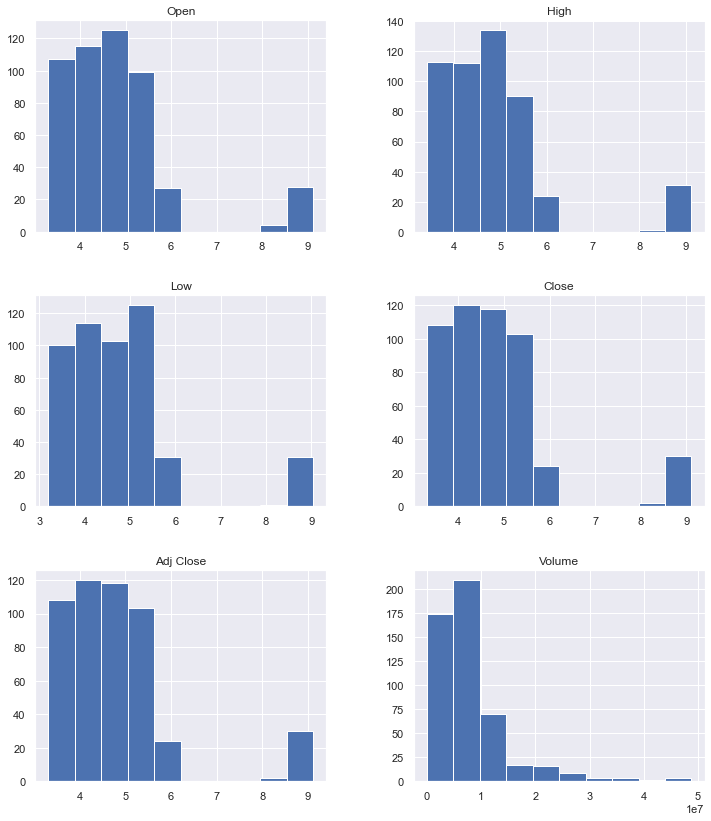

In [452]:
import seaborn as sns
sns.set()
df.hist(figsize=(12,14))

#### Data Visualisation

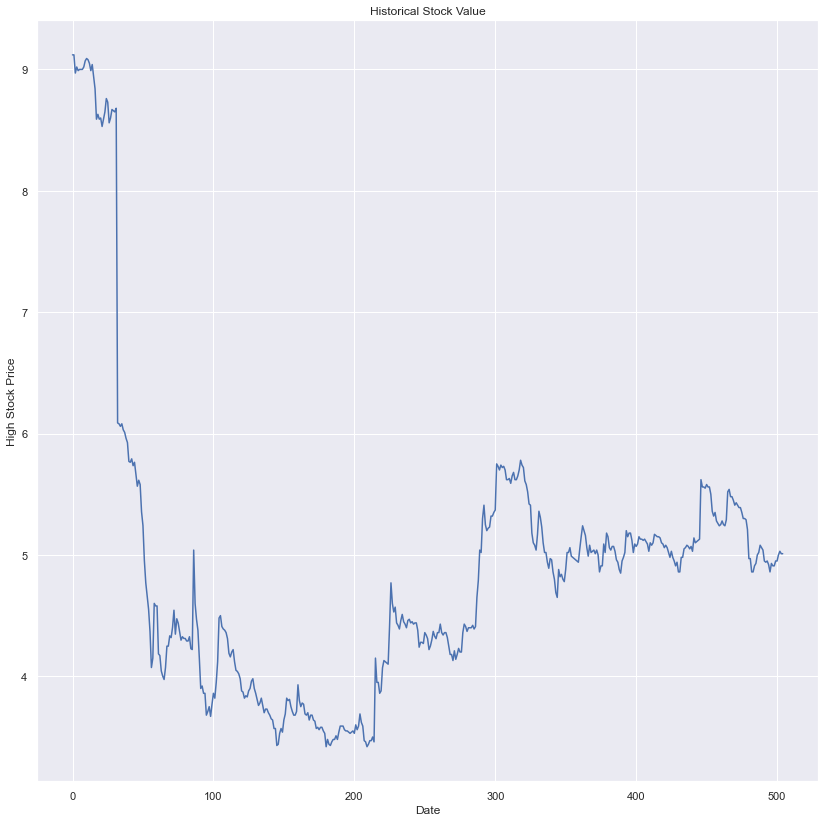

In [453]:
plt.figure(figsize=(14,14))
plt.plot(df['High'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('High Stock Price')
plt.show()

## 2. Pre-Processing of Data

### Normalization of Data

In [454]:
from sklearn.preprocessing import MinMaxScaler

dataframe = df.filter(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
print(dataframe.head())
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(dataframe)
type(scaled_df)

   Open  High   Low  Close  Adj Close   Volume
0  9.10  9.12  9.04   9.11       9.11  1131100
1  9.12  9.12  9.00   9.02       9.02  1001600
2  8.97  8.97  8.92   8.93       8.93  1219900
3  8.96  9.02  8.95   9.01       9.01  1127400
4  8.88  8.99  8.83   8.99       8.99  1668700


numpy.ndarray

In [455]:
#Converting the numpy.ndarray back to data frame
sc_df = pd.DataFrame(data=scaled_df, index = df.Date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
sc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,505.0,0.264108,0.210426,0.0,0.132716,0.261168,0.316151,1.0
High,505.0,0.257245,0.215071,0.0,0.124561,0.256140,0.308772,1.0
Low,505.0,0.271034,0.209754,0.0,0.137320,0.270548,0.321918,1.0
Close,505.0,0.262040,0.211412,0.0,0.131034,0.262069,0.313793,1.0
Adj Close,505.0,0.262040,0.211412,0.0,0.131034,0.262069,0.313793,1.0
Volume,505.0,0.166072,0.138918,0.0,0.081665,0.127151,0.195720,1.0


Check Basic Descriptive Statistics values after [0-1] normalization

### Train And Test Split of the Data set

In [456]:
sc_df.shape

(505, 6)

We are asked to use data until 31 Dec 2020 for training and the remaining data for testing. Therefore, we can note that the 252nd index corresponds to the cut off point. So we can use it to split our data into training and testing set.

We Also change it to numpy array to make it easier to work with LSTM

In [457]:
high_df = df.filter(['High'])
print(high_df.shape)
training_set = high_df.iloc[:252].values

(505, 1)


In [458]:
len(training_set)

252

In [459]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set = scaler.fit_transform(training_set)

## 2. LSTM Algorithm

Before continuing, we first generate a training data set that contains the stock's 30-day "high" price and forecasts its 31st-day "high" price. Divide the training data set into Xtrain and Ytrain segments. In this case, the Xtrain dataset is independent, but the Ytrain data set is dependent.

In [460]:
## Splitting the dataset into Xtrain and Ytrain datasets.
Xtrain = []
Ytrain = []
past_days_taken = 30
for i in range(past_days_taken, len(training_set)):
  Xtrain.append(training_set[i-past_days_taken:i, 0])
  Ytrain.append(training_set[i, 0])
  if i<= past_days_taken+1:
    print(Xtrain)
    print(Ytrain)
    print()

[array([1.        , 1.        , 0.97368421, 0.98245614, 0.97719298,
       0.97894737, 0.97894737, 0.97894737, 0.98245614, 0.99122807,
       0.99473684, 0.99298246, 0.9877193 , 0.97719298, 0.98596491,
       0.96842105, 0.95087719, 0.90701754, 0.91403509, 0.90701754,
       0.90877193, 0.89649123, 0.90701754, 0.91754386, 0.93684211,
       0.93157895, 0.90175439, 0.90877193, 0.92105263, 0.91929825])]
[0.917543859649123]

[array([1.        , 1.        , 0.97368421, 0.98245614, 0.97719298,
       0.97894737, 0.97894737, 0.97894737, 0.98245614, 0.99122807,
       0.99473684, 0.99298246, 0.9877193 , 0.97719298, 0.98596491,
       0.96842105, 0.95087719, 0.90701754, 0.91403509, 0.90701754,
       0.90877193, 0.89649123, 0.90701754, 0.91754386, 0.93684211,
       0.93157895, 0.90175439, 0.90877193, 0.92105263, 0.91929825]), array([1.        , 0.97368421, 0.98245614, 0.97719298, 0.97894737,
       0.97894737, 0.97894737, 0.98245614, 0.99122807, 0.99473684,
       0.99298246, 0.9877193 , 0.97

In [461]:
#Convert these data to np.array and Reshape
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
Xtrain.shape

(222, 30, 1)

### Develop LSTM model

In [462]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

neurons = 60

## First LSTM layer
model.add(LSTM(neurons, return_sequences=True, input_shape= (Xtrain.shape[1], 1))) 
## Second LSTM layer, no more layer for lstm so return_sequence is false
model.add(LSTM(neurons, return_sequences= False)) 

## Adding Dense layer which always have 25 neurons by default
model.add(Dense(25)) 
model.add(Dense(1))

In [463]:
##Compile  model
model.compile(optimizer='adam', loss='mse')

In [464]:
## Fiting model with given training dataset
history_data = model.fit(Xtrain, Ytrain, batch_size=50, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100
4/4 - 16s - loss: 0.0186 - val_loss: 0.0022 - 16s/epoch - 4s/step
Epoch 2/100
4/4 - 0s - loss: 0.0067 - val_loss: 0.0030 - 280ms/epoch - 70ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0037 - val_loss: 0.0065 - 281ms/epoch - 70ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0044 - val_loss: 0.0049 - 280ms/epoch - 70ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0037 - val_loss: 0.0029 - 248ms/epoch - 62ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0032 - val_loss: 0.0039 - 241ms/epoch - 60ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0029 - val_loss: 0.0044 - 246ms/epoch - 62ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0031 - val_loss: 0.0037 - 277ms/epoch - 69ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0031 - val_loss: 0.0026 - 257ms/epoch - 64ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0030 - val_loss: 0.0032 - 227ms/epoch - 57ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0029 - val_loss: 0.0039 - 227ms/epoch - 57ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0029 - val_loss: 0.0036 - 224ms/epoch - 56ms/step
Epoch 13/100
4/4 - 0s - loss

### Visualize train and validation loss

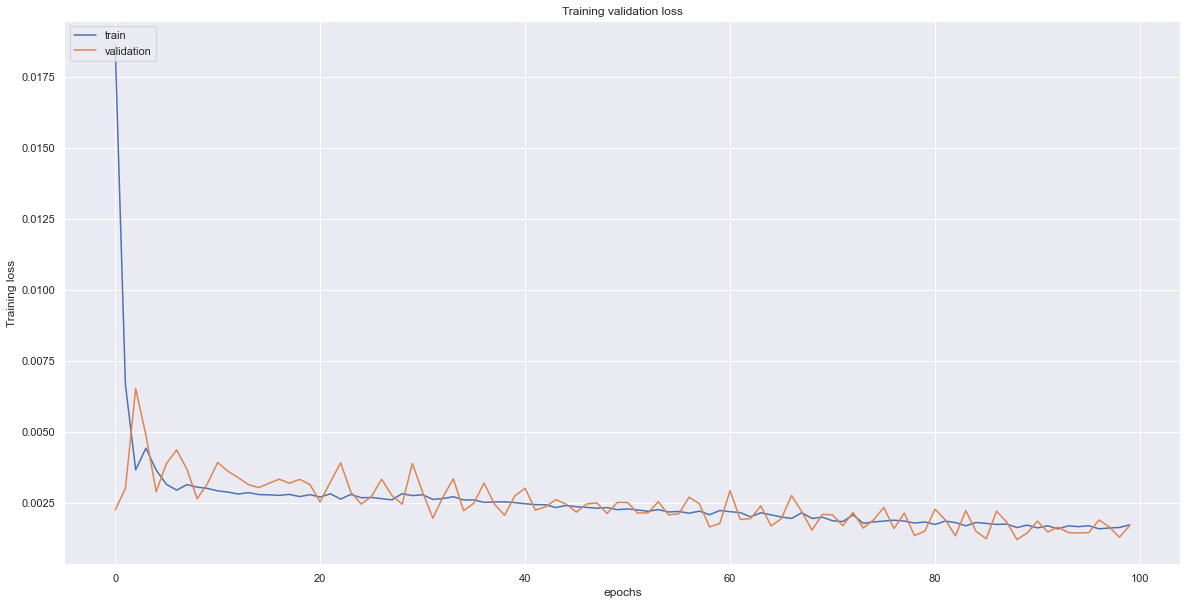

In [465]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title('Training validation loss')
plt.plot(history_data.history['loss'])
plt.plot(history_data.history['val_loss'])
plt.ylabel('Training loss')
plt.xlabel('epochs')
plt.legend(['train' , 'validation'], loc = 'upper left')
plt.show()

## Testing and Evaluation

In [466]:
#testing_data30 = sc_df.iloc[252-past_days_taken: ,1:2]
test_set = high_df.iloc[252-past_days_taken:].values
test_set = scaler.fit_transform(test_set)

Xtest = []
Ytest = high_df.iloc[252:,:].values
for i in range(past_days_taken, len(test_set)):
  Xtest.append(test_set[i-past_days_taken:i, 0])
Xtest = np.array(Xtest)
Xtest.shape

(253, 30)

In [467]:
## Reshape data from 2 Dimensional to 3 Dimensional
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1 ))
print(Xtest.shape)
print(Ytest.shape)

(253, 30, 1)
(253, 1)


In [468]:
predictions = model.predict(Xtest)
predictions = scaler.inverse_transform(predictions)
predictions.shape

8/8 [==============================] - 1s 7ms/step


(253, 1)

#### RMSE

In [469]:
rmse=np.sqrt(np.mean(((predictions- Ytest)**2)))
rmse

0.23672857327815913

Hence as our RMSE values lies between 0.2 and 0.5, we can determine that our model can relatively predict the data accurately.

C:\Users\Hp\AppData\Local\Temp\ipykernel_11368\1613328808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


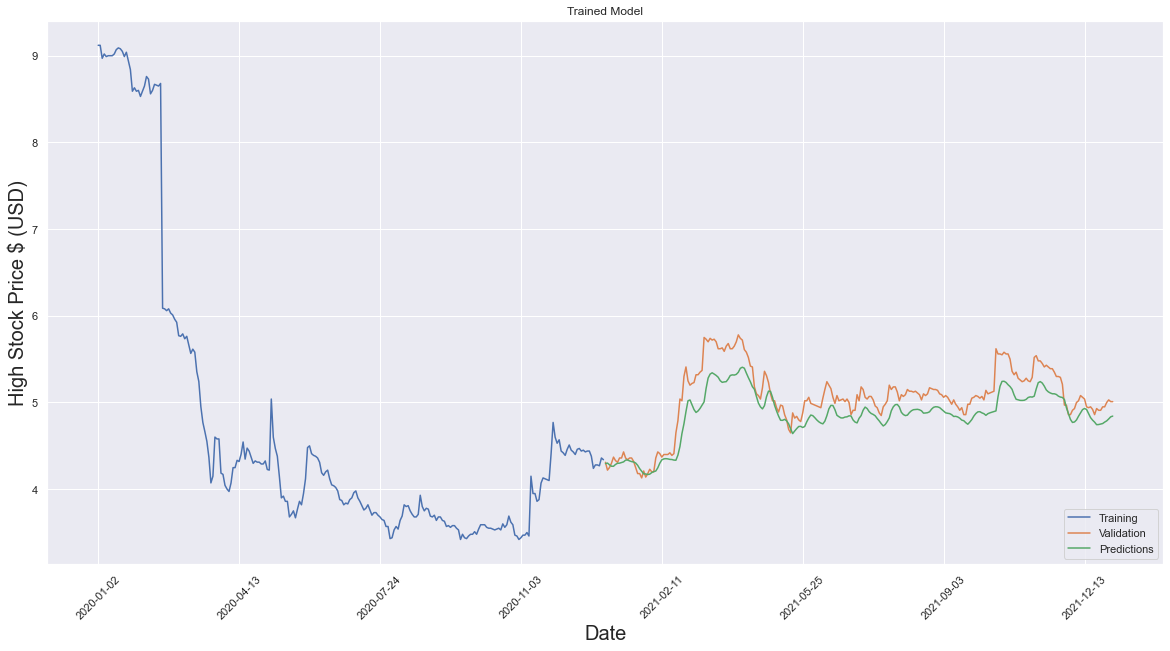

In [470]:
## Ploting data to graph train and validation
training = high_df.iloc[:252]
validation = high_df.iloc[252:]
validation['Predictions'] = predictions

## Visualize trainning, validating and predicting values in graph
plt.figure(figsize=(20,10))
plt.title('Trained Model')
plt.xticks(range(0,df.shape[0],70),df['Date'].loc[::70],rotation=45)
plt.xlabel('Date', fontsize=20)
plt.ylabel('High Stock Price $ (USD)', fontsize=20)
plt.plot(training['High'])
plt.plot(validation[['High', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='lower right')
plt.show()